In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
# Load datasets
df_train_trans = pd.read_csv('../input/train_transaction.csv')
#df_test_trans = pd.read_csv('../input/test_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')
#df_test_identity = pd.read_csv('../input/test_identity.csv')

# Merge identity data
df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')
#df_test = df_test_trans.merge(df_test_identity, how='left', on='TransactionID')

# Drop TransactionID (if not useful)
df_train.drop(columns=['TransactionID'], inplace=True, errors='ignore')
#df_test.drop(columns=['TransactionID'], inplace=True, errors='ignore')

# Select only numerical columns
X = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'], errors='ignore')
y = df_train['isFraud']

# Handle missing values
df_train.fillna(0, inplace=True)

# Train-test split (BEFORE SCALING)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

del df_train_trans, df_train_identity

In [ ]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)

Validation Accuracy: 0.82
Validation Precision: 0.09
Validation Recall: 0.44
Validation F1 Score: 0.15

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90    113975
           1       0.09      0.44      0.15      4133

    accuracy                           0.82    118108
   macro avg       0.53      0.64      0.52    118108
weighted avg       0.95      0.82      0.87    118108



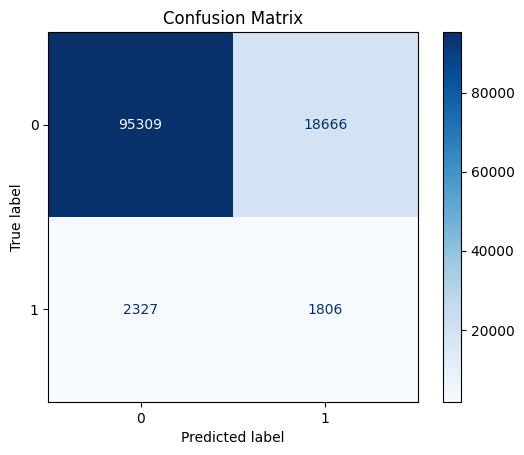

In [3]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Initialize & train RandomForest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = rf.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print results
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation F1 Score: {f1:.2f}")

# Show detailed classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()